In [3]:
import pandas as pd
from sodapy import Socrata

client = Socrata("data.cdc.gov", None)
results = client.get("unsk-b7fc", limit = 200000)

In [28]:
df = pd.DataFrame.from_records(results)

In [29]:
df.head(3)

,date,mmwr_week,location,distributed,distributed_janssen,distributed_moderna,distributed_pfizer,distributed_unk_manuf,dist_per_100k,distributed_per_100k_12plus,...,administered_dose1_recip_5pluspop_pct,series_complete_5plus,series_complete_5pluspop_pct,administered_5plus,admin_per_100k_5plus,distributed_per_100k_5plus,series_complete_moderna_5plus,series_complete_pfizer_5plus,series_complete_janssen_5plus,series_complete_unk_manuf_5plus
0,2021-11-22T00:00:00.000,47,AS,75120,600,20700,53820,0,158508,203483,...,82.1,31274,72.5,66939,155275,174252,8472,22247,555,0
1,2021-11-22T00:00:00.000,47,RP,34190,3800,23100,7290,0,158787,183374,...,88.6,15786,77.5,33834,166073,167820,11686,1761,2339,0
2,2021-11-22T00:00:00.000,47,TN,10201600,459500,3976260,5765840,0,149383,174818,...,59.8,3362976,52.4,7992789,124487,158889,1233500,1904902,215172,9402


In [30]:
df['date'] = pd.to_datetime(df['date']).dt.date

In [31]:
df['date'].min()

datetime.date(2020, 12, 13)

In [32]:
df['distributed_janssen'] = df['distributed_janssen'].astype(int)
df['distributed_moderna'] = df['distributed_moderna'].astype(int)
df['distributed_pfizer'] = df['distributed_pfizer'].astype(int)
df['distributed'] = df['distributed'].astype(int)

In [34]:
# filter states
abbr_state = pd.read_csv('abbr-name.csv', header = None)
df = df[df['location'].isin(abbr_state[0])]
df['location'].unique()

array(['TN', 'GA', 'DE', 'NJ', 'WV', 'VT', 'MA', 'OH', 'CA', 'IL', 'MN',
       'VA', 'NV', 'NH', 'CT', 'LA', 'ND', 'AZ', 'ME', 'WI', 'MO', 'HI',
       'KS', 'IN', 'NC', 'WY', 'UT', 'CO', 'NY', 'AR', 'IA', 'WA', 'FL',
       'MI', 'OR', 'DC', 'AL', 'ID', 'MS', 'SD', 'NE', 'AK', 'SC', 'TX',
       'RI', 'PA', 'OK', 'MT', 'NM', 'MD', 'KY'], dtype=object)

In [35]:
import chart_studio.plotly as py
import plotly.offline as po
import plotly.graph_objs as pg
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.graph_objects as go
from plotly.subplots import make_subplots

### Vaccine Distribution By Date And Location

In [36]:
def distribution_by_location_date(to_date):
    
    df_filter = df[df['date'] == to_date]
    
    fig_geo = go.Figure(data = go.Choropleth(
    locations = df_filter['location'],
    z = df_filter['distributed'],
    locationmode='USA-states',
    colorscale='Blues',
    autocolorscale=False,
    text = df['location'],
    marker_line_color='white',
    colorbar_title="Daily Number of Vaccine Distributed"
    ))

    fig_geo.update_layout(
        title_text='Number of Vaccine Distributed',
        geo = dict(
            scope='usa',
            projection=go.layout.geo.Projection(type = 'albers usa'),
            showlakes=True, # lakes
            lakecolor='rgb(255, 255, 255)'),)

    return fig_geo.show()

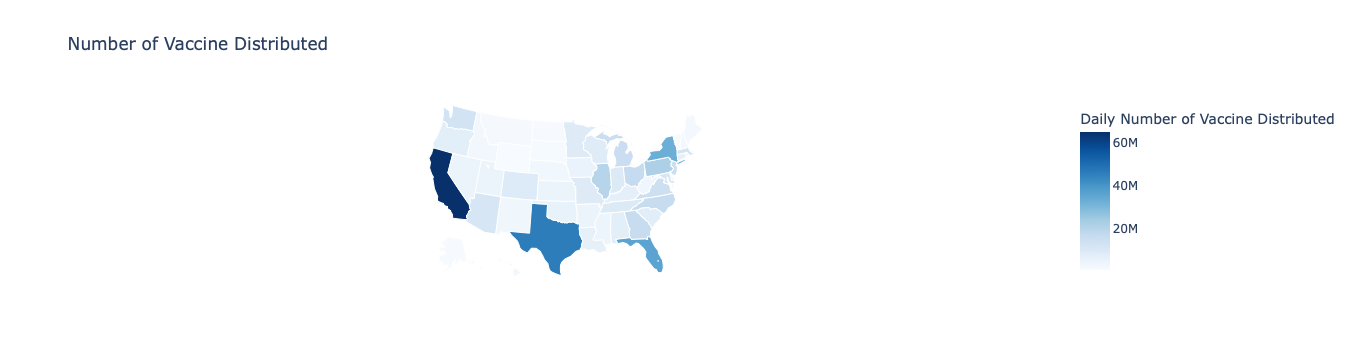

In [39]:
distribution_by_location_date(pd.to_datetime('2021-11-05'))

### Total Vaccine Distribution Trend

In [40]:
def distribution_compare(to_date, state):
    df_filter = df[df['date'] <= to_date]
    df_filter = df_filter[df_filter['location'] == state]
    
    fig_compare = make_subplots(rows=2, cols=2)
    
    fig_compare.add_trace(go.Bar(x = df_filter['date'],
                                     y = df_filter['distributed_janssen'],
                                     name = "J&J"),
                         row=1, col=1)
    
    fig_compare.add_trace(go.Bar(x = df_filter['date'],
                                     y = df_filter['distributed_moderna'],
                                     name = 'moderna'),
                         row=1, col=2)
    
    fig_compare.add_trace(go.Bar(x = df_filter['date'],
                                         y = df_filter['distributed_pfizer'],
                                         name = 'pfizer'),
                         row=2, col=1)
    
    fig_compare.add_trace(go.Bar(x = df_filter['date'],
                                         y = df_filter['distributed'],
                                         name = 'ALL'),
                         row=2, col=2)
    
    fig_compare.update_yaxes(range=[0, 18000000])
    fig_compare.update_layout(title_text='Vaccine Distribution Trend')  
    return fig_compare.show()

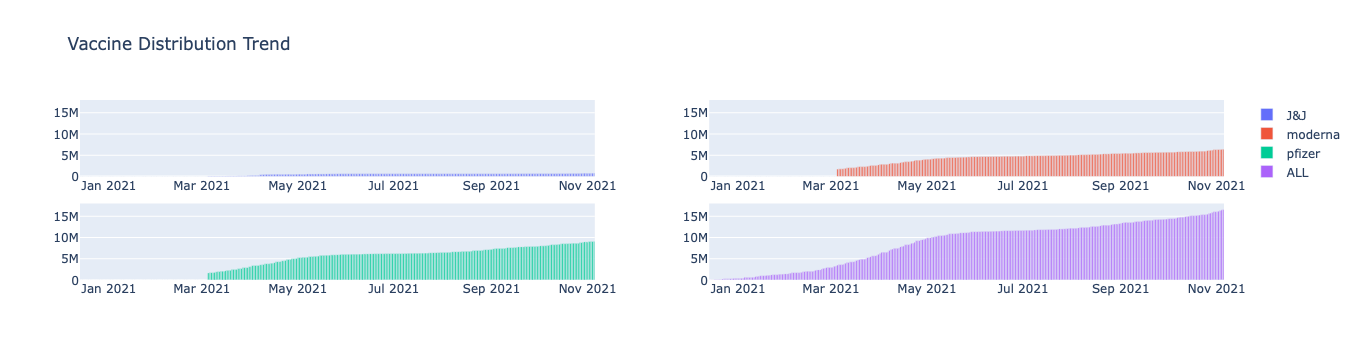

In [41]:
distribution_compare(pd.to_datetime('2021-11-05'), 'NC')

### Vaccine Progress Trend

In [42]:
def number_of_recipients(to_date, state):
    
    df['administered_dose1_pop_pct'] = df['administered_dose1_pop_pct'].astype(float)
    df['series_complete_pop_pct'] = df['series_complete_pop_pct'].astype(float)
    df['additional_doses_vax_pct'] = df['additional_doses_vax_pct'].astype(float)
    
    df_filter = df[df['date'] <= to_date]
    df_filter = df_filter[df_filter['location'] == state]
    
    fig_pct = make_subplots(rows=3, cols=1)
    
    fig_pct.add_trace(go.Bar(x = df_filter['date'],
                                     y = df_filter['administered_dose1_pop_pct'],
                                     name = "pct_recieved_at_least_one_dose"),
                         row=1, col=1)
    
    fig_pct.add_trace(go.Bar(x = df_filter['date'],
                                     y = df_filter['series_complete_pop_pct'],
                                     name = 'pct_fully_vaccinated'),
                         row=2, col=1)
    
    fig_pct.add_trace(go.Bar(x = df_filter['date'],
                                     y = df_filter['additional_doses_vax_pct'],
                                     name = 'pct_recieved_booster'),
                         row=3, col=1)
    
    fig_pct.update_yaxes(range=[0, 100])
    fig_pct.update_layout(title_text='Percentage of Vaccinated Population')  
    return fig_pct.show()

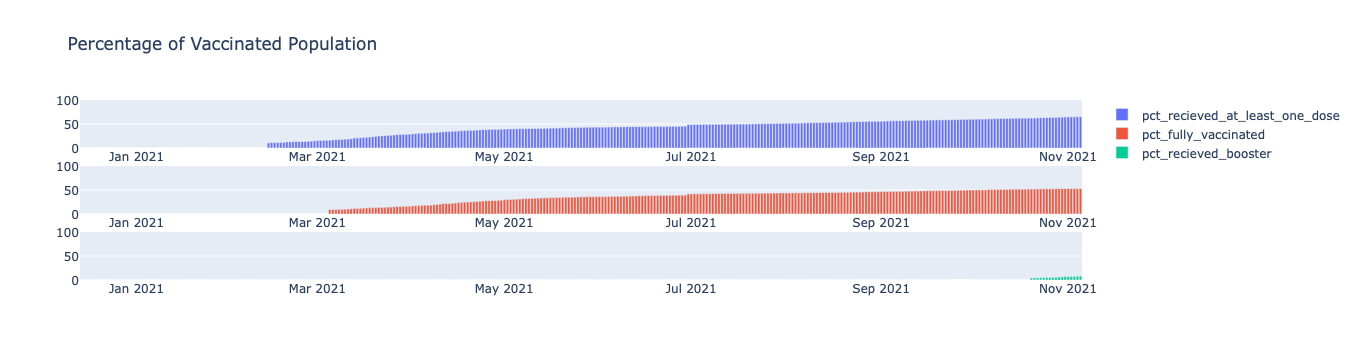

In [43]:
number_of_recipients(pd.to_datetime('2021-11-05'), 'NC')

### Dashboard

In [48]:
import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output
import plotly.graph_objects as go

app = dash.Dash(__name__)

app.layout = html.Div(
    children=[

html.Div(
    children=[
        html.Div(children = 'state', style={'fontSize': "24px"},className = 'menu-title'),
        dcc.Dropdown(
                    id = 'state',
                    options = [
                        {'label': state, 'value':str(state)} for state in df['location'].unique()
                    ], # State Filter
                    value = 'NC',
                    clearable = False,
                    searchable = False,
                    className = 'dropdown', style={'fontSize': "24px",'textAlign': 'center'},
                ),
            ],
    className = 'menu',
),
        
html.Div(
    children=[
        html.Div(children = 'date-picker-range', style={'fontSize': "24px"},className = 'menu-title'),
        dcc.DatePickerRange(
            id='date-picker-range',
            min_date_allowed = df['date'].min(),
            max_date_allowed = df['date'].max(),
            initial_visible_month = df['date'].max(),
            end_date = df['date'].max(),
            start_date = df['date'].min(),
            start_date_placeholder_text="Start Period",
            end_date_placeholder_text="End Period",
            calendar_orientation='vertical'  
        ),
            ],
    className = 'menu',
),
    
        html.Div(
            children=[
                html.Div(
                children = dcc.Graph(
                    id = 'daily_distribution',
                    figure = {},
                ),
                style={'width': '50%', 'display': 'inline-block'},
            ),
                html.Div(
                children = dcc.Graph(
                    id = 'type_distribution',
                    figure = {},
                ),
                style={'width': '50%', 'display': 'inline-block'},
            ),
                html.Div(
                children = dcc.Graph(
                    id = 'recipients',
                    figure = {},
                ),
                style={'width': '50%', 'display': 'inline-block'},
            ),
        ],
        className = 'double-graphs',
        ), 
    ]
)    

In [ ]:
@app.callback(
    Output("daily_distribution", "figure"),
    Input("date-picker-range", "start_date"), 
    Input("date-picker-range", "end_date"),
    Input("state", "value"))

def distribution_by_location_date(start_date, end_date, state):
    df_filter = df[df['date'] == pd.to_datetime(end_date)]
    
    fig_geo = go.Figure(data = go.Choropleth(
    locations = df_filter['location'],
    z = df_filter['distributed'],
    locationmode='USA-states',
    colorscale='Blues',
    autocolorscale=False,
    text = df['location'],
    marker_line_color='white',
    colorbar_title="Daily Number of Vaccine Distributed"
    ))

    fig_geo.update_layout(
        title_text='Number of Vaccine Distributed',
        geo = dict(
            scope='usa',
            projection=go.layout.geo.Projection(type = 'albers usa'),
            showlakes=True, # lakes
            lakecolor='rgb(255, 255, 255)'),)

    return fig_geo

@app.callback(
    Output("type_distribution", "figure"), 
    Input("date-picker-range", "start_date"), 
    Input("date-picker-range", "end_date"),
    Input("state", "value"))

def distribution_compare(start_date, end_date, state):
    df_filter = df[df['date'] <= pd.to_datetime(end_date)]
    df_filter = df[df['date'] >= pd.to_datetime(start_date)]
    df_filter = df_filter[df_filter['location'] == state]
    
    fig_compare = make_subplots(rows=2, cols=2)
    
    fig_compare.add_trace(go.Bar(x = df_filter['date'],
                                     y = df_filter['distributed_janssen'],
                                     name = "J&J"),
                         row=1, col=1)
    
    fig_compare.add_trace(go.Bar(x = df_filter['date'],
                                     y = df_filter['distributed_moderna'],
                                     name = 'moderna'),
                         row=1, col=2)
    
    fig_compare.add_trace(go.Bar(x = df_filter['date'],
                                         y = df_filter['distributed_pfizer'],
                                         name = 'pfizer'),
                         row=2, col=1)
    
    fig_compare.add_trace(go.Bar(x = df_filter['date'],
                                         y = df_filter['distributed_pfizer'] + df_filter['distributed_moderna'] + df_filter['distributed_janssen'],
                                         name = 'ALL'),
                         row=2, col=2)
    
    fig_compare.update_yaxes(range=[0, 15000000])
    fig_compare.update_layout(title_text='Vaccine Distribution Trend')  
    return fig_compare

@app.callback(
    Output("recipients", "figure"), 
    Input("date-picker-range", "start_date"), 
    Input("date-picker-range", "end_date"),
    Input("state", "value"))
  
def number_of_recipients(start_date, end_date, state):
    
    df['administered_dose1_pop_pct'] = df['administered_dose1_pop_pct'].astype(float)
    df['series_complete_pop_pct'] = df['series_complete_pop_pct'].astype(float)
    df['additional_doses_vax_pct'] = df['additional_doses_vax_pct'].astype(float)
    
    df_filter = df[df['date'] <= pd.to_datetime(end_date)]
    df_filter = df[df['date'] >= pd.to_datetime(start_date)]
    df_filter = df_filter[df_filter['location'] == state]
    
    fig_pct = make_subplots(rows=2, cols=2)
    
    fig_pct.add_trace(go.Bar(x = df_filter['date'],
                                     y = df_filter['administered_dose1_pop_pct'],
                                     name = "pct_recieved_at_least_one_dose"),
                         row=1, col=1)
    
    fig_pct.add_trace(go.Bar(x = df_filter['date'],
                                     y = df_filter['series_complete_pop_pct'],
                                     name = 'pct_fully_vaccinated'),
                         row=1, col=2)
    
    fig_pct.add_trace(go.Bar(x = df_filter['date'],
                                     y = df_filter['additional_doses_vax_pct'],
                                     name = 'pct_recieved_booster'),
                         row=2, col=1)
    
    
    fig_pct.update_layout(title_text='Percentage of Vaccinated Population')  
    return fig_pct

app.run_server(debug=True, use_reloader=False) 

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/



INFO:__main__:Dash is running on http://127.0.0.1:8050/



 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


In [31]:
end_date = pd.to_datetime('2021-11-01')
df_filter = df[pd.to_datetime(df['date']).dt.date < end_date]